## Applying Flux Sampling to a Plant Metabolic Model

### Methods 

Analyses were conducted in an `IPython` notebook environment (`Python` version 3.5.2; `Anaconda` version 4.1.1; `Jupyter` version 1.0.0; [Fernando and Granger](2007)) using the `cobra` package (version 0.4.0; [Ebrahim et al. 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3751080/pdf/1752-0509-7-74.pdf)) along with the `Gurobi Solver` (version 6.5.2; [Gurobi 2010](http://www.gurobi.com/documentation/8.0/refman/index.html)) for optimization and the `OptGPSampler` sampler which implements an adaptation of the Artificial Centering Hit-and-Run algorithm [(Kaufman and Smith, 1998)](https://pubsonline.informs.org/doi/abs/10.1287/opre.46.1.84) tailored towards high-dimensional metabolic networks [(Megchelenbrink et al. 2014)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0086587).

The previously-published [Arnold and Nikolosk (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4081344/pdf/1380.pdf) metabolic model for *Arabidopsis thaliana* suits the purpose of the proposed analyses in that it is species-specific, manually curated, compartmentalized, mass-balanced, and obeys the law of conservation of energy. With its 407 metabolites and 549 reactions the model compiles to a recent knowledge base on confirmed metabolic reactions in the photosynthetic cells of *A. thaliana*. Optimal biomass production, as defined by the authors was set as an objective function. 

For sampling, the upper flux (F<sub>u</sub>) and lower flux (F<sub>l</sub>) of the objective function was set to the maximum possible value as calculated by FVA for optimal and suboptimal (80% of the optimal) biomass production. Sampling distributions of the four reactions which are both essential (such that 0 is not in [F<sub>l</sub>,F<sub>u</sub>]) and which can hold a flux range greater that 0.001 (such that |F<sub>u</sub> - F<sub>l</sub>| > 0.01) under both conditions were computed as shown for N=200,000 samples using the sampling function in the cobra toolbox with the `OptGPSampler` sampler. 

In [1]:
import cobra
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import sample
from cobra.flux_analysis import flux_variability_analysis
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

# MODEL SET-UP

ANmodel = cobra.io.read_sbml_model("ArabidopsisCoreModel1.xml")

# Objective Function
print(ANmodel.objective)

cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00020 and ATCG00680 and ATCG00280 and ATCG00270 and ATCG00580 and ATCG00570 and ATCG00710 and ATCG00080 and ATCG00550 and ATCG00070 and ATCG00560 and ATCG00220 and ATCG00700 and (AT5G66570 or AT3G50820) and AT1G06680 and (AT4G21280 or AT4G05180) and AT1G79040 and AT1G44575 and ATCG00690 and AT3G21055 and AT2G30570 and AT2G06520 and AT1G67740 and ATCG00300)' for <Reaction PSII_h at 0x7efc9411e160>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '2*(ATCG00540 and ATCG00720 and AT4G03280 and ATCG00730 and ATCG00600 and ATCG00590 and AT2G26500 and ATCG00210)' for <Reaction Cytb6f_h at 0x7efc8b3ff780>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '8*(ATCG00490) and 8*(AT5G38430 or AT5G38420 or AT1G67090 or AT5G38410)' for <Reaction RBC_h at 0x7efc8b392dd8>
cobra/core/reaction.py:394 UserWarning: malformed gene_reaction_rule '4*(AT3G26650 or AT1G12900) or (2*(AT3G26650 or 

Maximize
-1.0*Bio_opt_reverse_faabb + 1.0*Bio_opt


In [2]:
# Changing the directionality of Fum_c to Mal_c to go the other way (day-time model) 
r = ANmodel.reactions.get_by_id('FumHA_c')
r.add_metabolites({ANmodel.metabolites.get_by_id('Fum_c'): +2})
r.add_metabolites({ANmodel.metabolites.get_by_id('H2O_c'): +2})
r.add_metabolites({ANmodel.metabolites.get_by_id('Mal_c'): -2})
print(r.reaction)
print(r.bounds)
print("Directionality changed. Dyson et al. 2016 \n")

# Setting up the export reactions
def create_exp_r(model,ident,name,subsys,subs=None, stoich1=[-1], prod=None, stoich2=[1]):
    '''Creates and export reactions for a specified metabolite.'''
    r = cobra.Reaction(ident)
    r.name = name
    r.subsystem = subsys
    if subs is not None:
        for i,m in enumerate(subs):
            r.add_metabolites({model.metabolites.get_by_id(m): stoich1[i]})
    else:
        pass
    if prod is not None:
        for i,m in enumerate(prod):
            r.add_metabolites({model.metabolites.get_by_id(m): stoich2[i]})
    else:
        pass
    model.add_reaction(r)
    print("{} reaction added to the model!".format(r.reaction))

# Creating a Carbon Storage Reactions which takes Malate, Fumarate, Sucrose, Citrate, and Starch as Inputs 
carbostore = cobra.Metabolite('CStore',formula='C',
    name='Carbon Storage Molecule',
    compartment='c')
ANmodel.add_metabolites(carbostore)
create_exp_r(ANmodel,'Fum_CStore','Fum Storage','CO2 Storage',['Fum_c'],[-1],['CStore'],[4])
create_exp_r(ANmodel,'Starch_CStore','Starch Storage','CO2 Storage',['starch1_h'],[-1],['CStore'],[6])
create_exp_r(ANmodel,'Mal_CStore','Mal Storage','CO2 Storage',['Mal_c'],[-1],['CStore'],[4])
create_exp_r(ANmodel,'Suc_CStore','Suc Storage','CO2 Storage',['Suc_c'],[-1],['CStore'],[12])
#create_exp_r(model,'Cit_CStore','Cit Storage','CO2 Storage',['Cit_c'],[-1],['CStore'],[6])
create_exp_r(ANmodel,'Ex_CStore','C export','CO2 Storage, export',['CStore'],[-1])

Mal_c --> Fum_c + H2O_c
(0.0, 1000.0)
Directionality changed. Dyson et al. 2016 

Fum_c --> 4 CStore reaction added to the model!
starch1_h --> 6 CStore reaction added to the model!
Mal_c --> 4 CStore reaction added to the model!
Suc_c --> 12 CStore reaction added to the model!
CStore -->  reaction added to the model!


In [3]:
# ANmodel.objective = ANmodel.reactions.get_by_id('Bio_opt')
# ANmodel.objective_direction = 'maximize'
# fva = flux_variability_analysis(ANmodel)
# print(fva.loc['Bio_opt'][0])
# print(fva.loc['Ex_CStore'][0])
# print(fva.loc['Fum_CStore'][0])
# print(fva.loc['Mal_CStore'][0])
# print(fva.loc['Suc_CStore'][0])
# print(fva.loc['Starch_CStore'][0])

# r = ANmodel.reactions.get_by_id('Bio_opt')
# r.lower_bound = 0.0
# r.upper_bound = 1000.0
# ANmodel.objective = ANmodel.reactions.get_by_id('Ex_CStore')
# ANmodel.objective_direction = 'maximize'
# fva = flux_variability_analysis(ANmodel)
# print("Flux values of optimal carbon storage")
# print(fva.loc['Bio_opt'][0])
# print(fva.loc['Ex_CStore'][0])
# print(fva.loc['Fum_CStore'][0])
# print(fva.loc['Mal_CStore'][0])
# print(fva.loc['Suc_CStore'][0])
# print(fva.loc['Starch_CStore'][0])

# r = ANmodel.reactions.get_by_id('Bio_opt')
# r.lower_bound = 0.005*0.99
# r.upper_bound = 0.005*1.1
# ANmodel.objective = ANmodel.reactions.get_by_id('Ex_CStore')
# ANmodel.objective_direction = 'maximize'
# fva = flux_variability_analysis(ANmodel)
# print("Flux values of optimal carbon storage under optimal biomass")
# print(fva.loc['Bio_opt'][0])
# print(fva.loc['Ex_CStore'][0])
# print(fva.loc['Fum_CStore'][0])
# print(fva.loc['Mal_CStore'][0])
# print(fva.loc['Suc_CStore'][0])
# print(fva.loc['Starch_CStore'][0])

# r = ANmodel.reactions.get_by_id('Bio_opt')
# r.lower_bound = 0.005*0.79
# r.upper_bound = 0.005*0.81
# fva = flux_variability_analysis(ANmodel)
# print("Flux values of optimal carbon storage under near-optimal biomass")
# print(fva.loc['Bio_opt'][0])
# print(fva.loc['Ex_CStore'][0])
# print(fva.loc['Fum_CStore'][0])
# print(fva.loc['Mal_CStore'][0])
# print(fva.loc['Suc_CStore'][0])
# print(fva.loc['Starch_CStore'][0])

# ANmodel.objective = ANmodel.reactions.get_by_id('Bio_opt')
# ANmodel.objective_direction = 'maximize'
# fva1 = flux_variability_analysis(ANmodel)
# print("Flux values of near-optimal biomass only")
# print(fva.loc['Bio_opt'][0])
# print(fva.loc['Ex_CStore'][0])
# print(fva.loc['Fum_CStore'][0])
# print(fva.loc['Mal_CStore'][0])
# print(fva.loc['Suc_CStore'][0])
# print(fva.loc['Starch_CStore'][0])


In [4]:
# FLUX SAMPLING FOR OPTIMAL SOLUTIONS

ANmodel.objective = ANmodel.reactions.get_by_id('Bio_opt')
ANmodel.objective_direction = 'maximize'
fva = flux_variability_analysis(ANmodel)
print(fva.loc['Bio_opt'][0])
print(fva.loc['Ex_CStore'][0])
print(fva.loc['Fum_CStore'][0])
print(fva.loc['Mal_CStore'][0])
print(fva.loc['Suc_CStore'][0])
print(fva.loc['Starch_CStore'][0])

# Using flux variability analysis to pick out all essential reactions 
# which can carry a range of flux to achieve the optimal solution
print(fva.loc['Bio_opt'][0])
total_reacs = [r.id for r in ANmodel.reactions]
flux_range = []
flux_range_req = []
flux_range_opt = []
for r in total_reacs:
    val = fva.loc[r]
    ma = val[0]
    mi = val[1]
    if abs(ma-mi)>0.001:
        flux_range.append(r)
        if (mi<=0 and ma>=0):
            flux_range_opt.append(r)
        else:
            flux_range_req.append(r)
            
print(len(flux_range_req))

r = ANmodel.reactions.get_by_id('Bio_opt')
r.lower_bound = 0.005*0.99
r.upper_bound = 0.005*1.1
print(r.bounds)


0.00500154137831
2.29775992516
0.57443998129
-1.86033007181e-13
-4.57653084758e-14
-8.78806230241e-14
0.00500154137831
15
(0.00495, 0.0055000000000000005)


In [5]:
n = 100000; #number of samples 
littleplant = 12 #set seed 

start = time.time()
samples = cobra.flux_analysis.sample(ANmodel,n, method='optgp', processes=1, seed=littleplant)
end = time.time()
print("Optgp sampler finished")
print(end-start)

savename = "ANModel_n{}_Opt.csv".format(n)
np.savetxt(savename, samples, delimiter=",")

print(samples.shape)
total_reacs = [r.id for r in ANmodel.reactions]
#np.savetxt('ReactionList.txt', total_reacs, delimiter=",", fmt="%s")

Optgp sampler finished
1105.816719532013
(100000, 554)


In [6]:
# FLUX SAMPLING FOR NEAR OPTIMAL SOLUTIONS

r = ANmodel.reactions.get_by_id('Bio_opt')
r.lower_bound = 0.0
r.upper_bound = 1000.0
ANmodel.objective = ANmodel.reactions.get_by_id('Ex_CStore')
ANmodel.objective_direction = 'maximize'
fva = flux_variability_analysis(ANmodel)
print("Flux values of optimal carbon storage")
print(fva.loc['Bio_opt'][0])
print(fva.loc['Ex_CStore'][0])
print(fva.loc['Fum_CStore'][0])
print(fva.loc['Mal_CStore'][0])
print(fva.loc['Suc_CStore'][0])
print(fva.loc['Starch_CStore'][0])

r = ANmodel.reactions.get_by_id('Bio_opt')
r.lower_bound = 0.005*0.99
r.upper_bound = 0.005*1.1
ANmodel.objective = ANmodel.reactions.get_by_id('Ex_CStore')
ANmodel.objective_direction = 'maximize'
fva = flux_variability_analysis(ANmodel)
print("Flux values of optimal carbon storage under optimal biomass")
print(fva.loc['Bio_opt'][0])
print(fva.loc['Ex_CStore'][0])
print(fva.loc['Fum_CStore'][0])
print(fva.loc['Mal_CStore'][0])
print(fva.loc['Suc_CStore'][0])
print(fva.loc['Starch_CStore'][0])

r = ANmodel.reactions.get_by_id('Bio_opt')
r.lower_bound = 0.005*0.79
r.upper_bound = 0.005*0.81
fva = flux_variability_analysis(ANmodel)
print("Flux values of optimal carbon storage under near-optimal biomass")
print(fva.loc['Bio_opt'][0])
print(fva.loc['Ex_CStore'][0])
print(fva.loc['Fum_CStore'][0])
print(fva.loc['Mal_CStore'][0])
print(fva.loc['Suc_CStore'][0])
print(fva.loc['Starch_CStore'][0])

ANmodel.objective = ANmodel.reactions.get_by_id('Bio_opt')
ANmodel.objective_direction = 'maximize'
fva1 = flux_variability_analysis(ANmodel)
print("Flux values of near-optimal biomass only")
print(fva.loc['Bio_opt'][0])
print(fva.loc['Ex_CStore'][0])
print(fva.loc['Fum_CStore'][0])
print(fva.loc['Mal_CStore'][0])
print(fva.loc['Suc_CStore'][0])
print(fva.loc['Starch_CStore'][0])

# Checking essential reactions at 80% of optimality 
# r = ANmodel.reactions.get_by_id('Bio_opt')
# r.lower_bound = fva.loc['Bio_opt'][0]*0.80
# r.upper_bound = fva.loc['Bio_opt'][0]*0.80
# print(r.bounds)
# fva1 = flux_variability_analysis(ANmodel)
print(fva1.loc['Bio_opt'][0])
total_reacs = [r.id for r in ANmodel.reactions]
flux_range_lower = []
flux_range_req_lower = []
flux_range_opt_lower = []
for r in total_reacs:
    val = fva1.loc[r]
    ma = val[0]
    mi = val[1]
    if abs(ma-mi)>0.0001:
        flux_range_lower.append(r)
        if (mi<=0 and ma>=0):
            flux_range_opt_lower.append(r)
        else:
            flux_range_req_lower.append(r)           
print(len(flux_range_req_lower))

# Functions which are essential in both conditions 
both_req = intersection(flux_range_req,flux_range_req_lower)
print(both_req)

Flux values of optimal carbon storage
-4.1738497092e-17
142.857142857
35.7142857143
35.7142857143
2.54008922386e-12
1.97127259571e-11
Flux values of optimal carbon storage under optimal biomass
0.00495
3.81315448686
0.953288621716
0.384768301216
8.32686765068e-12
1.43748031022e-11
Flux values of optimal carbon storage under near-optimal biomass
0.00395
33.2146686008
8.30366715019
7.84999941969
1.89108349576e-12
3.26460729794e-12
Flux values of near-optimal biomass only
0.00395
33.2146686008
8.30366715019
7.84999941969
1.89108349576e-12
3.26460729794e-12
0.00405
209
['P5CRNAD_c', 'MalDH1_h', 'GluSeADA_m', 'Tr_CO2m']


In [7]:
start = time.time()
samples_nearopt = cobra.flux_analysis.sample(ANmodel,n, method='optgp', processes=1, seed=littleplant)
end = time.time()
print("Optgp sampler finished")
print(end-start)

savename = "ANModel_n{}_NearOpt.csv".format(n)
np.savetxt(savename, samples_nearopt, delimiter=",")

Optgp sampler finished
1117.7237215042114


In [8]:
# Model dimension 

counter = 0
for column in samples:
    x = sum(samples[column])
    counter = counter + 1 
    if -10 < x < 10:
        print(column)
        print(x)

print(counter)
print(samples.shape)
print(" ")

counter = 0
for column in samples_nearopt:
    x = sum(samples_nearopt[column])
    counter = counter + 1 
    if -10 < x < 10:
        print(column)
        print(x)

print(counter)
print(samples_nearopt.shape)

Bio_AA
6.826351932770422
Bio_CLim
0.040660025223597136
Bio_NLim
0.027905761108254663
554
(100000, 554)
 
Bio_CLim
0.8320937445677522
Bio_NLim
0.594109841871423
554
(100000, 554)


In [9]:
# Getting the upper and lower bounds of reactions of interest 
#pick_reacs = both_req
pick_reacs = ['Im_CO2','Ex_CStore','Bio_opt','Ex_CStore','Fum_CStore','Mal_CStore','Suc_CStore','Starch_CStore']
pick_reacs_names = [ANmodel.reactions.get_by_id(r) for r in pick_reacs]

for r in pick_reacs:
    print(r)
    reac = ANmodel.reactions.get_by_id(r)
    print(reac.reaction)
    print(reac.bounds)
    print(" ")

Im_CO2
 --> CO2_c
(0.0, 1000.0)
 
Ex_CStore
CStore --> 
(0.0, 1000.0)
 
Bio_opt
0.58559 ATP_c + 230.67099 Ala_c + 74.68248 Arg_c + 70.5431 Asn_c + 101.03805 Asp_c + 0.49638 CTP_c + 31.11756 Cys_c + 12.0349 Frc_c + 67.20727 Fum_m + 0.09401 GABA_c + 0.40478 GTP_c + 18.47868 Glc_c + 51.2643 Gln_c + 116.39401 Glu_c + 273.48273 Gly_c + 33.2443 His_c + 89.82686 Ile_c + 158.77115 Leu_c + 103.59352 Lys_c + 779.97036 M_DASH_ACP_h + 50.99641 Mal_m + 2.60958 Mas_c + 33.61497 Met_c + 1.58654 Orn_h + 66.66173 Phe_c + 108.03688 Pro_c + 0.37924 SA_h + 0.98709 SCA_m + 147.49851 Ser_c + 30.66837 Suc_c + 136.6831 Thr_c + 0.57736 Tre_c + 16.87103 Trp_c + 47.02921 Tyr_c + 0.61307 UTP_c + 146.26883 Val_c + 363.88306 cellulose2_c + 0.68091 dATP_c + 0.40366 dCTP_c + 0.37141 dGTP_c + 0.69281 dTTP_c + 294.86155 starch2_h + 2.84043 urea_m --> 779.97036 ACP_h + 3125.54 H_h
(0.00395, 0.004050000000000001)
 
Ex_CStore
CStore --> 
(0.0, 1000.0)
 
Fum_CStore
Fum_c --> 4 CStore
(0.0, 1000.0)
 
Mal_CStore
Mal_c --> 4 

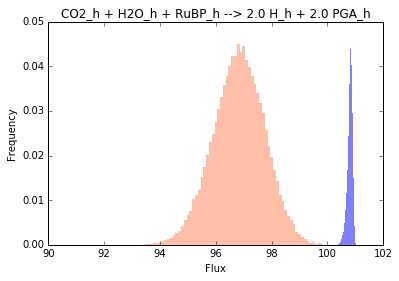

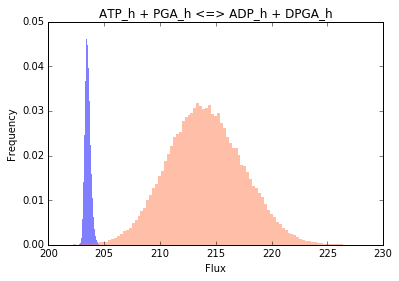

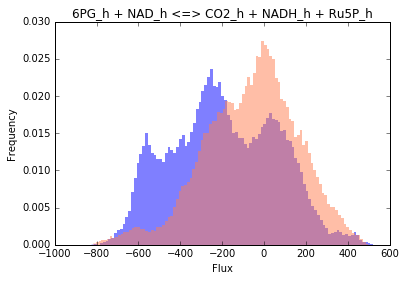

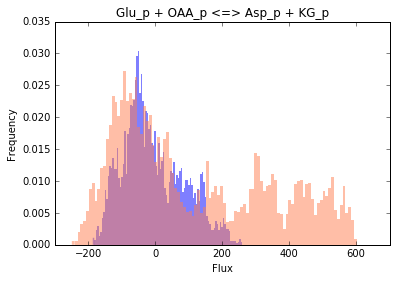

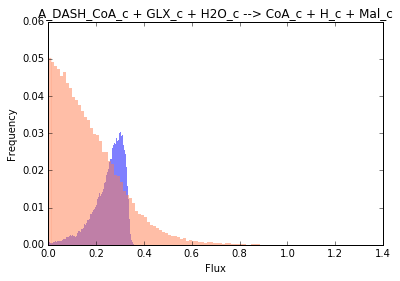

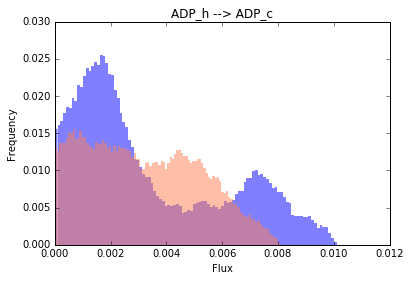

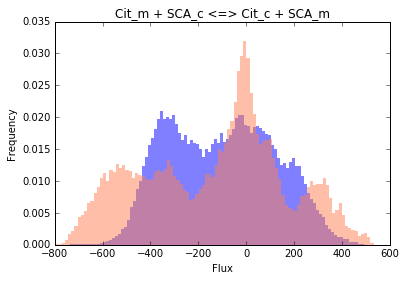

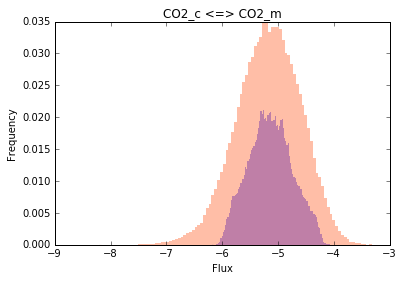

In [13]:
# Plotting the distributions of the reactions 
pick_index = []
for ind, r in enumerate(total_reacs):
    if r in pick_reacs:
        pick_index.append(ind)
        
pick_index = [5,6,99,169,128,325,352,378]

bins = 100
for i in pick_index: 
    x = samples.iloc[:,i]
    y = samples_nearopt.iloc[:,i]
    weights_x = np.ones_like(x)/float(len(x))
    weights_y = np.ones_like(y)/float(len(y))
    plt.hist(x, bins, alpha=0.5, weights=weights_x, color = "blue", lw=0)
    plt.hist(y, bins, alpha=0.5, weights=weights_y, color = "coral", lw=0)
    plt.xlabel('Flux')
    plt.ylabel('Frequency')
    plt.title('{}'.format(ANmodel.reactions[i].reaction))
    plt.show()
    plt.close()
    
# Saving all distribution plots to a PDF 
pdf = matplotlib.backends.backend_pdf.PdfPages("ShowPlots_n{}.pdf".format(n))
bins = 100
for i in pick_index: 
    x = samples.iloc[:,i]
    y = samples_nearopt.iloc[:,i]
    weights_x = np.ones_like(x)/float(len(x))
    weights_y = np.ones_like(y)/float(len(y))
    plt.hist(x, bins, alpha=0.5, weights=weights_x, color = "blue", lw=0)
    plt.hist(y, bins, alpha=0.5, weights=weights_y, color = "coral", lw=0)
    plt.xlabel('Flux')
    plt.ylabel('Frequency')
    plt.title('{}'.format(ANmodel.reactions[i].reaction))
    pdf.savefig()
    plt.close()
pdf.close()



In [11]:
# Saving all distribution plots to a PDF 
pdf = matplotlib.backends.backend_pdf.PdfPages("DistributionPlots_n{}.pdf".format(n))
bins = 100
for i in range(samples.shape[1]): 
    x = samples.iloc[:,i]
    y = samples_nearopt.iloc[:,i]
    weights_x = np.ones_like(x)/float(len(x))
    weights_y = np.ones_like(y)/float(len(y))
    plt.hist(x, bins, alpha=0.5, weights=weights_x, color = "blue", lw=0)
    plt.hist(y, bins, alpha=0.5, weights=weights_y, color = "coral", lw=0)
    plt.xlabel('Flux')
    plt.ylabel('Frequency')
    plt.title('{}: {}'.format(i,ANmodel.reactions[i].reaction))
    pdf.savefig()
    plt.close()
pdf.close()
